In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import re,string,unicodedata
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import datetime
%matplotlib inline
%load_ext tensorboard

In [2]:
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

In [3]:
true['category'] = 1
false['category'] = 0

In [4]:
true.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
false.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
news = pd.concat([true,false])

<AxesSubplot:xlabel='category', ylabel='count'>

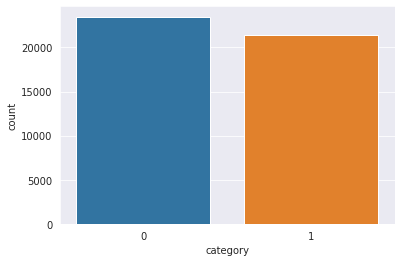

In [7]:
sns.set_style("darkgrid")
# Count occurences of both real and fake news
sns.countplot(x=news.category)

In [8]:
news['text'] = news['text'] + " " + news['title']
del news['title']
del news['subject']
del news['date']

In [9]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [10]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['text']=news['text'].apply(denoise_text)

In [11]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(news.text)

In [12]:
x_train,x_test,y_train,y_test = train_test_split(news.text,news.category,random_state = 27)

In [13]:
max_features = 10000
maxlen = 300

In [14]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [15]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [16]:
# Model Hyperparameters
batch_size = 256
epochs = 3
embed_size = 100

In [17]:
model = Sequential([
                    Embedding(max_features, embed_size, input_length=maxlen),
                    Bidirectional(LSTM(150, return_sequences=True, dropout=0.25)),
                    LSTM(100, dropout=0.1),
                    Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
                    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

2022-02-28 19:53:33.389192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:53:33.497731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:53:33.498467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 19:53:33.499657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2022-02-28 19:53:36.519729: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-28 19:53:36.519767: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-28 19:53:36.521630: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-02-28 19:53:36.732006: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-28 19:53:36.732193: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [19]:
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_test,y_test),
    callbacks=[tensorboard_callback]
)

2022-02-28 19:53:37.011269: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-02-28 19:53:41.635961: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/132 [..............................] - ETA: 13:04 - loss: 1.1778 - acc: 0.4414

2022-02-28 19:53:43.186066: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-28 19:53:43.186117: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/132 [..............................] - ETA: 1:09 - loss: 1.1728 - acc: 0.4961 

2022-02-28 19:53:43.584131: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-28 19:53:43.587812: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-02-28 19:53:43.725910: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 4919 callback api events and 4916 activity events. 
2022-02-28 19:53:43.788479: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-28 19:53:43.896960: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/fit/20220228-195336/train/plugins/profile/2022_02_28_19_53_43

2022-02-28 19:53:43.948978: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /kaggle/working/logs/fit/20220228-195336/train/plugins/profile/2022_02_28_19_53_43/5005c4ed8b46.trace.json.gz


  3/132 [..............................] - ETA: 1:11 - loss: 1.1687 - acc: 0.4922

2022-02-28 19:53:44.021516: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/logs/fit/20220228-195336/train/plugins/profile/2022_02_28_19_53_43

2022-02-28 19:53:44.026033: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /kaggle/working/logs/fit/20220228-195336/train/plugins/profile/2022_02_28_19_53_43/5005c4ed8b46.memory_profile.json.gz
2022-02-28 19:53:44.028000: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /kaggle/working/logs/fit/20220228-195336/train/plugins/profile/2022_02_28_19_53_43
Dumped tool data for xplane.pb to /kaggle/working/logs/fit/20220228-195336/train/plugins/profile/2022_02_28_19_53_43/5005c4ed8b46.xplane.pb
Dumped tool data for overview_page.pb to /kaggle/working/logs/fit/20220228-195336/train/plugins/profile/2022_02_28_19_53_43/5005c4ed8b46.overview_page.pb
Dumped tool data for input_pipeline.pb to /kaggle/working/log

132/132 [==============================] - 25s 149ms/step - loss: 0.3511 - acc: 0.9489 - val_loss: 0.1030 - val_acc: 0.9929
Epoch 2/3
132/132 [==============================] - 18s 135ms/step - loss: 0.0484 - acc: 0.9971 - val_loss: 0.0343 - val_acc: 0.9957
Epoch 3/3
132/132 [==============================] - 18s 135ms/step - loss: 0.0243 - acc: 0.9966 - val_loss: 0.0293 - val_acc: 0.9933


In [20]:
%tensorboard --logdir kaggle/working/logs/fit

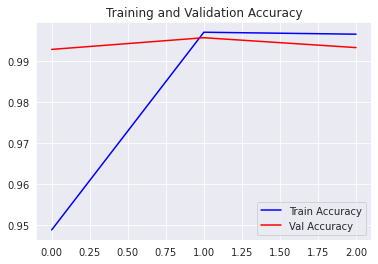

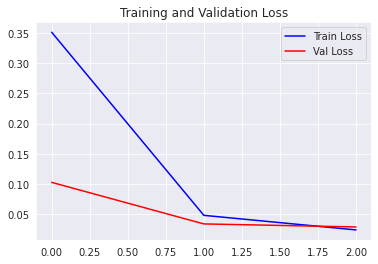

In [21]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.plot(acc, color='b', label='Train Accuracy')
plt.plot(val_acc, color='r', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(loss, color='b', label='Train Loss')
plt.plot(val_loss, color='r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()